\[SEP592\] 소프트웨어 특강 <데이터사이언스 입문>
# 3주차 실습 파트

> 강의일: 2021.03.18.

👤 실습담당자: 임채균 (KAIST 전산학부) &nbsp;&nbsp; | &nbsp;&nbsp; 📧 Email: rayote@kaist.ac.kr

---
<br />

#### &nbsp;&nbsp; *실습 목표*

*   참고서적<small>(김태영 저)</small>에서 모델의 레이어를 블록 형태로 표현하는 방법을 이해함.
*   Keras 환경에서 <u>CNN (Convolution Neural Network)의 구조 및 사용법</u>을 학습함.
*   사전학습된 VGG 모델을 Keras에서 사용하는 방법을 확인함.



<br />

#### &nbsp;&nbsp; *References*

*   김태영, “블록과 함께 하는 파이썬 딥러닝 케라스,” 디지털
북스, 2017.
  * 김태영의 케라스 블로그 <small>https://tykimos.github.io/lecture/</small>

<br />

---

##### *(참고)* 각각의 코드 셀의 실행시간을 자동으로 측정해주는 모듈을 설치함.

In [1]:
# 각 코드 셀의 실행시간 측정 모듈
!pip install ipython-autotime

time: 1.26 ms (started: 2021-03-20 15:03:46 +09:00)


In [2]:
%load_ext autotime

time: 382 µs (started: 2021-03-20 16:52:51 +09:00)


##### Keras 버전 차이로 실습 시 에러 발생하므로, 구버전으로 재설치

*   재설치 버전 
    - keras 2.3.1
    -   tensorflow 2.2.0 

In [2]:
import keras
print(keras.__version__)

import tensorflow as tf
print(tf.__version__)

2.4.3
2.2.0
time: 7.14 s (started: 2021-03-20 15:05:08 +09:00)


In [3]:
# 기존 keras 삭제하기
!pip uninstall -y keras
!pip uninstall -y tensorflow

# 구버전 재설치
!pip install keras==2.3.1
!pip install tensorflow==2.2.0

Found existing installation: Keras 2.4.3
Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
Found existing installation: tensorflow 2.2.0
Uninstalling tensorflow-2.2.0:
  Successfully uninstalled tensorflow-2.2.0
     |████████████████████████████████| 377 kB 2.1 MB/s 
  Using cached tensorflow-2.2.0-cp37-cp37m-macosx_10_11_x86_64.whl (175.3 MB)
time: 30.3 s (started: 2021-03-20 15:05:22 +09:00)


## **1. 레이어 구조의 블록 형태 표현방법**


케라스에서 사용되는 레이어(layer, 층) 개념에 대해서 알아봅니다. 케라스의 핵심 데이터 구조는 모델이고, 이 모델을 구성하는 것이 레이어입니다. 간단히 뉴런에 대해서 알아본 다음, 주요 레이어에 대해 기본 개념, 역할 등에 대해서 살펴보고, 레이어를 어떻게 쌓아서 모델을 만들 수 있는 지 알아봅니다. 기본적인 레이어 개념을 익히면 블록 쌓는 것 처럼 쉽게 구성할 수 있습니다. 다층 퍼셉트론 모델에서 사용되는 Dense 레이어를 중점으로 알아보겠습니다.

---

### **인간의 신경계를 모사한 뉴런이야기**

신경망에서 사용되는 뉴런은 인간의 신경계를 모사한 것입니다. 아래 왼쪽 그림이 인간의 뉴런이고, 오른쪽 그림이 이를 모델링한 것입니다.

* axon (축삭돌기) : 팔처럼 몸체에서 뻗어나와 다른 뉴런의 수상돌기와 연결됩니다.
* dendrite (수상돌기) : 다른 뉴런의 축삭 돌기와 연결되며, 몸체에 나뭇가지 형태로 붙어 있습니다.
* synapse (시냅스) : 축사돌기와 수상돌기가 연결된 지점입니다. 여기서 한 뉴런이 다른 뉴런으로 신호가 전달됩니다.

하나의 뉴런은 여러 다른 뉴런의 축삭돌기와 연결되어 있는데, 연결된 시냅스의 강도가 연결된 뉴런들의 영향력이 결정됩니다. 이러한 영향력의 합이 어떤 값을 초과하면 신호가 발생하여 축삭돌기를 통해서 다른 뉴런에게 신호가 전달되는 식입니다. 오른쪽 그림의 모델링과는 다음과 같이 매칭됩니다.

* x0, x1, x2 : 입력되는 뉴런의 축삭돌기로부터 전달되는 신호의 양
* w0, w1, w2 : 시냅스의 강도, 즉 입력되는 뉴런의 영향력을 나타냅니다.
* w0*x0 + w1*x1 + w2*x2 : 입력되는 신호의 양과 해당 신호의 시냅스 강도가 곱해진 값의 합계
* f : 최종 합계가 다른 뉴런에게 전달되는 신호의 양을 결정짓는 규칙, 이를 활성화 함수라고 부릅니다.

![neuron](http://tykimos.github.io/warehouse/2017-1-27_MLP_Layer_Talk_neuron.png)
(출처: http://cs231n.github.io/neural-networks-1/)

세 개의 신호를 받아 하나의 신호를 전달하는 뉴런을 블록으로 표현하면 다음과 같습니다. 녹색 블록은 시냅스의 강도, 노란색과 빨간색 블록은 연산자, 파란색 블록은 활성화 함수를 나타냅니다.

![lego_1](http://tykimos.github.io/warehouse/2017-1-27_MLP_Layer_Talk_lego_1.png)

만약 세 개의 신호가 서로 다른 뉴런 두 개에 전달된다고 한다면, 각 뉴런은 하나의 신호가 출력되므로, 총 두 개의 신호가 출력됩니다. 이를 블록으로 표현하면 다음과 같습니다.

![lego_2](http://tykimos.github.io/warehouse/2017-1-27_MLP_Layer_Talk_lego_2.png)

위와 같은 표현이지만 이를 겹쳐 표현하면 아래와 같습니다. 다시말해 세 개의 신호를 받는 뉴런 두 개를 표현 한 것입니다. 여기서 유심히 봐야할 점은 시냅스의 강도 즉 녹색 블록의 개수입니다. 세 개의 신호가 뉴런 두 개에 연결되므로 총 연결 경우의 수(3*2=6)인 6개가 됩니다.

![lego_3](http://tykimos.github.io/warehouse/2017-1-27_MLP_Layer_Talk_lego_3.png)

---

### **입출력을 모두 연결해주는 Dense 레이어**

Dense 레이어는 입력과 출력을 모두 연결해줍니다. 예를 들어 입력 뉴런이 4개, 출력 뉴런이 8개있다면 총 연결선은 32개(4*8=32) 입니다. 각 연결선에는 가중치(weight)를 포함하고 있는데, 이 가중치가 나타내는 의미는 연결강도라고 보시면 됩니다. 현재 연결선이 32개이므로 가중치도 32개입니다.

    가중치가 높을수록 해당 입력 뉴런이 출력 뉴런에 미치는 영향이 크고, 낮을수록 미치는 영향이 적다.

예를 들어 성별을 판단하는 문제있어서, 출력 뉴런의 값이 성별을 의미하고, 입력 뉴런에 머리카락길이, 키, 혈핵형 등이 있다고 가정했을 때, 머리카락길이의 가중치가 가장 높고, 키의 가중치가 중간이고, 혈핵형의 가중치가 가장 낮을 겁니다. 딥러닝 학습과정에서 이러한 가중치들이 조정됩니다.


#### *Dense 레이어 구성*

이렇게 입력 뉴런과 출력 뉴런을 모두 연결한다고 해서 전결합층이라고 불리고, 케라스에서는 Dense라는 클래스로 구현이 되어 있습니다. 아래는 Dense 클래스 사용 예제입니다.

    Dense(8, input_dim=4, activation='relu'))

주요 인자는 다음과 같습니다.
* 첫번째 인자 : 출력 뉴런의 수를 설정합니다.
* input_dim : 입력 뉴런의 수를 설정합니다.
* activation : 활성화 함수 설정합니다.
    * 'linear' : 디폴트 값, 입력뉴런과 가중치로 계산된 결과값이 그대로 출력으로 나옵니다.
    * 'relu' : rectifier 함수, 은익층에 주로 쓰입니다.
    * 'sigmoid' : 시그모이드 함수, 이진 분류 문제에서 출력층에 주로 쓰입니다.
    * 'softmax' : 소프트맥스 함수, 다중 클래스 분류 문제에서 출력층에 주로 쓰입니다.

Dense 레이어는 입력 뉴런 수에 상관없이 출력 뉴런 수를 자유롭게 설정할 수 있기 때문에 출력층으로 많이 사용됩니다. 이진 분류문제에서는 0과 1을 나타내는 출력 뉴런이 하나만 있으면 되기 때문에 아래 코드처럼 출력 뉴런이 1개이고, 입력 뉴런과 가중치를 계산한 값을 0에서 1사이로 표현할 수 있는 활성화 함수인 sigmoid을 사용합니다.

    Dense(1, input_dim=3, activation='sigmoid'))

이를 블록으로 표시하면 다음과 같습니다. 왼쪽 그림은 앞서 설명한 뉴런 상세 구조를 도식화 한 것이고, 오른쪽 그림은 이를 간단하게 도식화한 것이다. 왼쪽 그림에서 시냅스 강도가 녹색 블럭으로 표시되어 있다면, 중간 그림에서는 시냅스 강도가 연결선으로 표시되어 있고, 오른쪽 그림에서는 생략되어 있습니다. 생략되어 있더라도 입력 신호의 수와 출력 신호의 수만 알면 곱셈으로 쉽게 유추할 수 있습니다.

![lego_4](http://tykimos.github.io/warehouse/2017-1-27_MLP_Layer_Talk_lego_4.png)

다중클래스 분류문제에서는 클래스 수만큼 출력 뉴런이 필요합니다. 만약 세가지 종류로 분류한다면, 아래 코드처럼 출력 뉴런이 3개이고, 입력 뉴런과 가중치를 계산한 값을 각 클래스의 확률 개념으로 표현할 수 있는 활성화 함수인 softmax를 사용합니다.

    Dense(3, input_dim=4, activation='softmax'))

이를 블록으로 표시하면 다음과 같습니다. 입력 신호가 4개이고 출력 신호가 3개이므로 시냅스 강도의 개수는 12개입니다.

![lego_5](http://tykimos.github.io/warehouse/2017-1-27_MLP_Layer_Talk_lego_5.png)

Dense 레이어는 보통 출력층 이전의 은닉층으로도 많이 쓰이고, 영상이 아닌 수치자료 입력 시에는 입력층으로도 많이 쓰입니다. 이 때 활성화 함수로 'relu'가 주로 사용됩니다. 'relu'는 학습과정에서 역전파 시에 좋은 성능이 나는 것으로 알려져 있습니다.

    Dense(4, input_dim=6, activation='relu'))

이를 블록으로 표시하면 다음과 같습니다.

![lego_6](http://tykimos.github.io/warehouse/2017-1-27_MLP_Layer_Talk_lego_6.png)

또한 입력층이 아닐 때에는 이전층의 출력 뉴런 수를 알 수 있기 때문에 input_dim을 지정하지 않아도 됩니다. 아래 코드를 보면, 입력층에만 input_dim을 정의하였고, 이후 층에서는 input_dim을 지정하지 않았습니다.

    model.add(Dense(8, input_dim=4, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

이를 블록으로 표시하면 다음과 같습니다. 왼쪽 그림은 Dense 레이어 세 개를 도식화 한 것이고, 오른쪽 그림은 입력과 출력의 수에 맞게 연결하여 입력 신호가 인가되었을 때, 출력 신호가 나오는 것 까지의 구성을 표시한 것입니다. 이제 블록만 봐도 입력값이 4이고 출력값이 0에서 1까지 범위를 가지는 값이 나올 수 있도록 설계된 구조임을 알 수 있습니다. 활성화 함수가 sigmoid이기 때문에 이진 분류에 적합합니다.

![lego_7](http://tykimos.github.io/warehouse/2017-1-27_MLP_Layer_Talk_lego_7.png)

#### *실제 소스코드 구현*

쌓았던 블록을 실제 케라스로 구현해봅니다. 4개의 입력 값을 받아 이진 분류하는 문제를 풀 수 있는 모델입니다.

In [4]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

model.add(Dense(8, input_dim=4, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

time: 106 ms (started: 2021-03-20 15:29:36 +09:00)


케라스의 시각화 기능을 이용하여 구성된 레이어를 벡터 이미지 형태로 보실 수 있습니다. 블록과 비교해서 봤을 때 위아래만 바뀌었을 뿐 크게 차이가 없습니다.

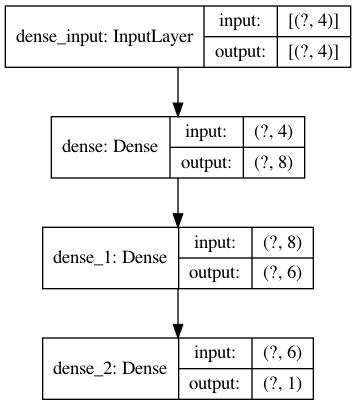

time: 362 ms (started: 2021-03-20 15:33:55 +09:00)


In [12]:
from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

%matplotlib inline

tf.keras.utils.plot_model(model, show_shapes=True)
#SVG(tf.keras.utils.plot_model(model, show_shapes=True).create(prog='dot', format='svg'))

# 모델 이미지 사이즈 조절 (dpi)
#SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

![model](http://tykimos.github.io/warehouse/2017-1-27-MLP_Layer_Talk_model.svg)

---

### 요약

신경망의 기본인 뉴런에 대해서 알아보고, 이를 다양한 방식으로 도식화 해봤습니다. 그리고 다층 퍼셉트론 모델에서 가장 기본이 되는 전결합층인 Dense 레이어와 Dense 레이어를 쌓는 법에 대해서 알아봤습니다.

## **2. CNN 모델의 기본 개념**

### **필터로 특징을 뽑아주는 컨볼루션(Convolution) 레이어**

케라스에서 제공되는 컨볼루션 레이어 종류에도 여러가지가 있으나 영상 처리에 주로 사용되는 Conv2D 레이어를 살펴보겠습니다. 레이어는 영상 인식에 주로 사용되며, 필터가 탑재되어 있습니다. 아래는 Conv2D 클래스 사용 예제입니다.

    Conv2D(32, (5, 5), padding='valid', input_shape=(28, 28, 1), activation='relu')
    
주요 인자는 다음과 같습니다.
* 첫번째 인자 : 컨볼루션 필터의 수 입니다.
* 두번째 인자 : 컨볼루션 커널의 (행, 열) 입니다.
* padding : 경계 처리 방법을 정의합니다.
    * 'valid' : 유효한 영역만 출력이 됩니다. 따라서 출력 이미지 사이즈는 입력 사이즈보다 작습니다.
    * 'same' : 출력 이미지 사이즈가 입력 이미지 사이즈와 동일합니다.
* input_shape : 샘플 수를 제외한 입력 형태를 정의 합니다. 모델에서 첫 레이어일 때만 정의하면 됩니다. 
    * (행, 열, 채널 수)로 정의합니다. 흑백영상인 경우에는 채널이 1이고, 컬러(RGB)영상인 경우에는 채널을 3으로 설정합니다. 
* activation : 활성화 함수 설정합니다.
    * 'linear' : 디폴트 값, 입력뉴런과 가중치로 계산된 결과값이 그대로 출력으로 나옵니다.
    * 'relu' : rectifier 함수, 은익층에 주로 쓰입니다.
    * 'sigmoid' : 시그모이드 함수, 이진 분류 문제에서 출력층에 주로 쓰입니다.
    * 'softmax' : 소프트맥스 함수, 다중 클래스 분류 문제에서 출력층에 주로 쓰입니다.

입력 형태는 다음과 같습니다. 
* image_data_format이 'channels_first'인 경우 (샘플 수, 채널 수, 행, 열)로 이루어진 4D 텐서입니다.
* image_data_format이 'channels_last'인 경우 (샘플 수, 행, 열, 채널 수)로 이루어진 4D 텐서입니다.

    image_data_format 옵션은 "keras.json" 파일 안에 있는 설정입니다. 콘솔에서 "vi ~/.keras/keras.json"으로 keras.json 파일 내용을 변경할 수 있습니다. 

출력 형태는 다음과 같습니다.
* image_data_format이 'channels_first'인 경우 (샘플 수, 필터 수, 행, 열)로 이루어진 4D 텐서입니다.
* image_data_format이 'channels_last'인 경우 (샘플 수, 행, 열, 필터 수)로 이루어진 4D 텐서입니다.
* 행과 열의 크기는 padding가 'same'인 경우에는 입력 형태의 행과 열의 크기가 동일합니다.

#### *예제*

간단한 예제로 컨볼루션 레이어와 필터에 대해서 알아보겠습니다. 입력 이미지는 채널 수가 1, 너비가 3 픽셀, 높이가 3 픽셀이고, 크기가 2 x 2인 필터가 하나인 경우를 레이어로 표시하면 다음과 같습니다. 단 image_data_format이 'channels_last'인 경우 입니다.

    Conv2D(1, (2, 2), padding='valid', input_shape=(3, 3, 1))
    
이를 도식화하면 다음과 같습니다.

![lego_1](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_1.png)

필터는 가중치를 의미합니다. 하나의 필터가 입력 이미지를 순회하면서 적용된 결과값을 모으면 출력 이미지가 생성됩니다. 여기에는 두 가지 특성이 있습니다. 
* 하나의 필터로 입력 이미지를 순회하기 때문에 순회할 때 적용되는 가중치는 모두 동일합니다. 이를 파라미터 공유라고 부릅니다. 이는 학습해야할 가중치 수를 현저하게 줄여줍니다.위치가 바뀌더라도 그 연결 가중치가 공유되기 때문에 위치에 무관하게 특징을 추출할 수 있습니다. 
* 출력에 영향을 미치는 영역이 지역적으로 제한되어 있습니다. 즉 그림에서 y~0~에 영향을 미치는 입력은 x~0~, x~1~, x~3~, x~4~으로 한정되어 있습니다. 이는 지역적인 특징을 잘 뽑아내게 되어 영상 인식에 적합합니다. 예를 들어 코를 볼 때는 코 주변만 보고, 눈을 볼 때는 눈 주변만 보면서 학습 및 인식하는 것입니다.

---

#### *가중치의 수*

이를 Dense 레이어와 컨볼루션 레이어와 비교를 해보면서 차이점을 알아보겠습니다. 영상도 결국에는 픽셀의 집합이므로 입력 뉴런이 9개 (3 x 3)이고, 출력 뉴런이 4개 (2 x 2)인 Dense 레이어로 표현할 수 있습니다. 

    Dense(4, input_dim=9))

이를 도식화하면 다음과 같습니다.

![lego_2](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_2.png)

가중치 즉 시냅스 강도는 녹색 블록으로 표시되어 있습니다. 

컨볼루션 레이어에서는 가중치 4개로 구성된 크기가 2 x 2인 필터를 적용하였을 때의 뉴런 상세 구조는 다음과 같습니다.

![lego_3](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_3.png)

필터가 지역적으로만 적용되어 출력 뉴런에 영향을 미치는 입력 뉴런이 제한적이므로 Dense 레이어와 비교했을 때, 가중치가 많이 줄어든 것을 보실 수 있습니다. 게다가 녹색 블록 상단에 표시된 빨간색, 파란색, 분홍색, 노란색끼리는 모두 동일한 가중치(파라미터 공유)이므로 결국 사용되는 가중치는 4개입니다. 즉 Dense 레이어에서는 36개의 가중치가 사용되었지만, 컨볼루션 레이어에서는 필터의 크기인 4개의 가중치만을 사용합니다.

#### *경계 처리 방법*

이번에는 경계 처리 방법에 대해서 알아봅니다. 컨볼루션 레이어 설정 옵션에는 `padding`가 있는데, 'valid'와 'same'으로 설정할 수 있습니다. 이 둘의 차이는 아래 그림에서 확인할 수 있습니다.

![lego_4](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_4.png)

'valid'인 경우에는 입력 이미지 영역에 맞게 필터를 적용하기 때문에 출력 이미지 크기가 입력 이미지 크기보다 작아집니다. 반면에 'same'은 출력 이미지와 입력 이미지 사이즈가 동일하도록 입력 이미지 경계에 빈 영역을 추가하여 필터를 적용합니다. 'same'으로 설정 시, 입력 이미지에 경계를 학습시키는 효과가 있습니다. 깊은 층을 가진 모델인 경우 'valid'인 경우 특징맵이 계속 작아져서 정보가 많이 손실되므로 필터를 통과하더라도 원본 사이즈가 유지될 수 있도록 'same'으로 설정합니다.

#### *필터 수*

다음은 필터의 개수에 대해서 알아봅니다. 입력 이미지가 단채널의 3 x 3이고, 2 x 2인 필터가 하나 있다면 다음과 같이 컨볼루션 레이어를 정의할 수 있습니다.

    Conv2D(1, (2, 2), padding='same', input_shape=(3, 3, 1))
    
이를 도식화하면 다음과 같습니다.

![lego_5](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_5.png)

만약 여기서 사이즈가 2 x 2 필터를 3개 사용한다면 다음과 같이 정의할 수 있습니다.

    Conv2D(3, (2, 2), padding='same', input_shape=(3, 3, 1))
    
이를 도식화하면 다음과 같습니다.

![lego_6](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_6.png)
    
여기서 살펴봐야할 것은 필터가 3개라서 출력 이미지도 필터 수에 따라 3개로 늘어났습니다. 총 가중치의 수는 3 x 2 x 2으로 12개입니다. 필터마다 고유한 특징을 뽑아 고유한 출력 이미지로 만들기 때문에 필터의 출력값을 더해서 하나의 이미지로 만들거나 그렇게 하지 않습니다. 필터에 대해 생소하신 분은 카메라 필터라고 생각하시면 됩니다. 스마트폰 카메라로 사진을 찍을 때 필터를 적용해볼 수 있는 데, 적용되는 필터 수에 따라 다른 사진이 나옴을 알 수 있습니다.

![filter](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_filter.png)

뒤에서 각 레이어를 블록처럼 쌓아올리기 위해서 약식으로 표현하면 다음과 같습니다.

![lego_7](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_7.png)

이 표현은 다음을 의미합니다.
* 입력 이미지 사이즈가 3 x 3 입니다.
* 2 x 2 커널을 가진 필터가 3개입니다. 가중치는 총 12개 입니다.
* 출력 이미지 사이즈가 3 x 3이고 총 3개입니다. 이는 채널이 3개다라고도 표현합니다.

다음은 입력 이미지의 채널이 여러 개인 경우를 살펴보겠습니다. 만약 입력 이미지의 채널이 3개이고 사이즈가 3 x 3이고, 사이즈가 2 x 2 필터를 1개 사용한다면 다음과 같이 컨볼루션 레이어를 정의할 수 있습니다.

    Conv2D(1, (2, 2), padding='same', input_shape=(3, 3, 3))

이를 도식화하면 다음과 같습니다.

![lego_8](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_8.png)

필터 개수가 3개인 것처럼 보이지만 이는 입력 이미지에 따라 할당되는 커널이고, 각 커널의 계산 값이 결국 더해져서 출력 이미지 한 장을 만들어내므로 필터 개수는 1개입니다. 이는 Dense 레이어에서 입력 뉴런이 늘어나면 거기에 상응하는 시냅스에 늘어나서 가중치의 수가 늘어나는 것과 같은 원리입니다. 가중치는 2 x 2 x 3으로 총 12개 이지만 필터 수는 1개입니다.

 이를 약식으로 표현하면 다음과 같습니다.

![lego_9](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_9.png)

이 표현은 다음을 의미합니다.
* 입력 이미지 사이즈가 3 x 3 이고 채널이 3개입니다.
* 2 x 2 커널을 가진 필터가 1개입니다. 채널마다 커널이 할당되어 총 가중치는 12개 입니다.
* 출력 이미지는 사이즈가 3 x 3 이고 채널이 1개입니다.







마지막으로 입력 이미지의 사이즈가 3 x 3이고 채널이 3개이고, 사이즈가 2 x 2인 필터가 2개인 경우를 살펴보겠습니다. 

    Conv2D(2, (2, 2), padding='same', input_shape=(3, 3, 3))
    
이를 도식화하면 다음과 같습니다. 

![lego_10](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_10.png)

필터가 2개이므로 출력 이미지도 2개입니다. 약식 표현은 다음과 같습니다.

![lego_11](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_11.png)

이 표현은 다음을 의미합니다.
* 입력 이미지 사이즈가 3 x 3 이고 채널이 3개입니다.
* 2 x 2 커널을 가진 필터가 2개입니다. 채널마다 커널이 할당되어 총 가중치는 3 x 2 x 2 x 2로 24개 입니다.
* 출력 이미지는 사이즈가 3 x 3 이고 채널이 2개입니다.

---

### **사소한 변화를 무시해주는 맥스풀링(Max Pooling) 레이어**

컨볼루션 레이어의 출력 이미지에서 주요값만 뽑아 크기가 작은 출력 영상을 만듭니다. 이것은 지역적인 사소한 변화가 영향을 미치지 않도록 합니다. 

    MaxPooling2D(pool_size=(2, 2))

주요 인자는 다음과 같습니다.
* pool_size : 수직, 수평 축소 비율을 지정합니다. (2, 2)이면 출력 영상 크기는 입력 영상 크기의 반으로 줄어듭니다.

예를 들어, 입력 영상 크기가 4 x 4이고, 풀 크기를 (2, 2)로 했을 때를 도식화하면 다음과 같습니다. 녹색 블록은 입력 영상을 나타내고, 노란색 블록은 풀 크기에 따라 나눈 경계를 표시합니다. 해당 풀에서 가장 큰 값을 선택하여 파란 블록으로 만들면, 그것이 출력 영상이 됩니다. 가장 오른쪽은 맥스풀링 레이어를 약식으로 표시한 것입니다.

![lego_12](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_12.png)

이 레이어는 영상의 작은 변화라던지 사소한 움직임이 특징을 추출할 때 크게 영향을 미치지 않도록 합니다. 영상 내에 특징이 세 개가 있다고 가정했을 때, 아래 그림에서 첫 번째 영상을 기준으로 두 번째 영상은 오른쪽으로 이동하였고, 세 번째 영상은 약간 비틀어 졌고, 네 번째 영상은 조금 확대되었지만, 맥스풀링한 결과는 모두 동일합니다. 얼굴 인식 문제를 예를 들면, 맥스풀링의 역할은 사람마다 눈, 코, 입 위치가 조금씩 다른데 이러한 차이가 사람이라고 인식하는 데 있어서는 큰 영향을 미치지 않게 합니다.

![lego_13](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_13.png)

---

### **영상을 일차원으로 바꿔주는 플래튼(Flatten) 레이어**

CNN에서 컨볼루션 레이어나 맥스풀링 레이어를 반복적으로 거치면 주요 특징만 추출되고, 추출된 주요 특징은 전결합층에 전달되어 학습됩니다. 컨볼루션 레이어나 맥스풀링 레이어는 주로 2차원 자료를 다루지만 전결합층에 전달하기 위해선 1차원 자료로 바꿔줘야 합니다. 이 때 사용되는 것이 플래튼 레이어입니다. 사용 예시는 다음과 같습니다.

    Flatten()
    
이전 레이어의 출력 정보를 이용하여 입력 정보를 자동으로 설정되며, 출력 형태는 입력 형태에 따라 자동으로 계산되기 때문에 별도로 사용자가 파라미터를 지정해주지 않아도 됩니다. 크기가 3 x 3인 영상을 1차원으로 변경했을 때는 도식화하면 다음과 같습니다.

![lego_14](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_14.png)

---

### **한 번 쌓아보기**

지금까지 알아본 레이어를 이용해서 간단한 컨볼루션 신경망 모델을 만들어보겠습니다. 먼저 간단한 문제를 정의해봅시다. 손으로 삼각형, 사각형, 원을 손으로 그린 이미지가 있고 이미지 크기가 8 x 8이라고 가정해봅니다. 삼각형, 사각형, 원을 구분하는 3개의 클래스를 분류하는 문제이기 때문에 출력 벡터는 3개여야 합니다. 필요하다고 생각하는 레이어를 구성해봤습니다.

![lego_22](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_22.png)

#### *레이어 블록 디자인*


* 컨볼루션 레이어 : 입력 이미지 크기 8 x 8, 입력 이미지 채널 1개, 필터 크기 3 x 3, 필터 수 2개, 경계 타입 'same', 활성화 함수 'relu'

![lego_15](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_15.png)



* 맥스풀링 레이어 : 풀 크기 2 x 2

![lego_16](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_16.png)



* 컨볼루션 레이어 : 입력 이미지 크기 4 x 4, 입력 이미지 채널 2개, 필터 크기 2 x 2, 필터 수 3개, 경계 타입 'same', 활성화 함수 'relu'

![lego_17](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_17.png)



* 맥스풀링 레이어 : 풀 크기 2 x 2

![lego_18](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_18.png)


* 플래튼 레이어

![lego_19](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_19.png)


* 댄스 레이어 : 입력 뉴런 수 12개, 출력 뉴런 수 8개, 활성화 함수 'relu'

![lego_20](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_20.png)

* 댄스 레이어 : 입력 뉴런 수 8개, 출력 뉴런 수 3개, 활성화 함수 'softmax'

![lego_21](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_21.png)


모든 레이어 블록이 준비되었으니 이를 조합해 봅니다. 입출력 크기만 맞으면 블록 끼우듯이 합치면 됩니다. 참고로 케라스 코드에서는 가장 첫번째 레이어를 제외하고는 입력 형태를 자동으로 계산하므로 이 부분은 신경쓰지 않아도 됩니다. 레이어를 조립하니 간단한 컨볼루션 모델이 생성되었습니다. 이 모델에 이미지를 입력하면, 삼각형, 사각형, 원을 나타내는 벡터가 출력됩니다.

![lego_23](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_23.png)

#### *실제 소스코드 구현*

그럼 케라스 코드로 어떻게 구현하는 지 알아봅니다. 먼저 필요한 패키지를 추가하는 과정입니다. 케라스의 레이어는 'keras.layers'에 정의되어 있으며, 여기서 필요한 레이어를 추가합니다. 

In [13]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

time: 15.1 ms (started: 2021-03-20 15:37:32 +09:00)


Sequential 모델을 하나 생성한 뒤 위에서 정의한 레이어를 차례차레 추가하면 컨볼루션 모델이 생성됩니다.

In [14]:
model = Sequential()

model.add(Conv2D(2, (3, 3), padding='same', activation='relu', input_shape=(8, 8, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(3, (2, 2), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

time: 106 ms (started: 2021-03-20 15:37:49 +09:00)


생성한 모델을 케라스에서 제공하는 함수를 이용하여 가시화 시켜봅니다.

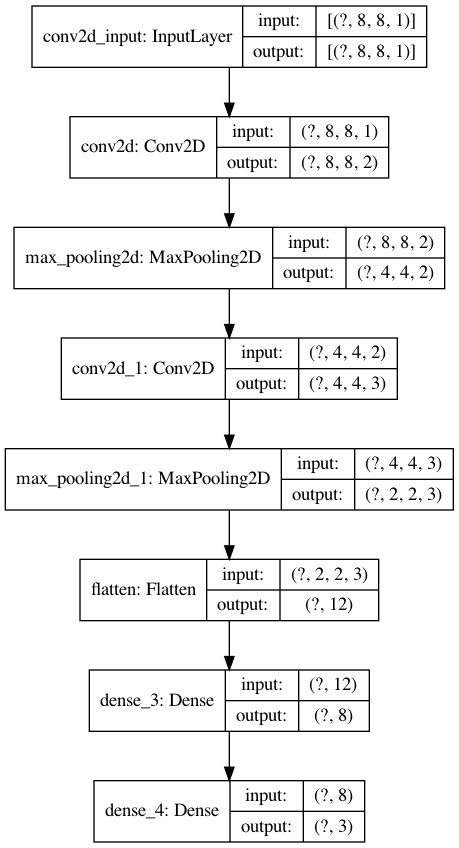

time: 399 ms (started: 2021-03-20 15:38:13 +09:00)


In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

tf.keras.utils.plot_model(model, show_shapes=True)
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# 모델 이미지 사이즈 조절 (dpi)
#SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

![model](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_model.svg)

---

### **요약**

컨볼루션 신경망 모델에서 사용되는 주요 레이어의 원리와 역할에 대해서 알아보았고 레이어를 조합하여 간단한 컨볼루션 신경망 모델을 만들어봤습니다.

## **3. CNN 모델 시작하기**

간단한 컨볼루션 신경망 모델을 만들어봅니다. 다음과 같은 순서로 진행하겠습니다.

1. 문제 정의하기
1. 데이터 준비하기
1. 데이터셋 생성하기
1. 모델 구성하기
1. 모델 학습과정 설정하기
1. 모델 학습시키기
1. 모델 평가하기

---

### **문제 정의하기**

좋은 예제와 그와 관련된 데이터셋도 공개된 것이 많이 있지만, 직접 문제를 정의하고 데이터를 만들어보는 것도 처럼 딥러닝을 접하시는 분들에게는 크게 도움이 될 것 같습니다. 컨볼루션 신경망 모델에 적합한 문제는 이미지 기반의 분류입니다. 따라서 우리는 직접 손으로 삼각형, 사각형, 원을 그려 이미지로 저장한 다음 이를 분류해보는 모델을 만들어보겠습니다. 문제 형태와 입출력을 다음과 같이 정의해봅니다.
* 문제 형태 : 다중 클래스 분류
* 입력 : 손으로 그린 삼각형, 사각형, 원 이미지
* 출력 : 삼각형, 사각형, 원일 확률을 나타내는 벡터

가장 처음 필요한 패키지를 불러오고, 매번 실행 시마다 결과가 달라지지 않도록 랜덤 시드를 명시적으로 지정합니다. 

In [16]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# 랜덤시드 고정시키기
np.random.seed(3)

time: 9.99 ms (started: 2021-03-20 15:38:33 +09:00)


---

### **데이터 준비하기**

손으로 그린 삼각형, 사각형, 원 이미지를 만들기 위해서는 여러가지 방법이 있을 수 있겠네요. 테블릿을 이용할 수도 있고, 종이에 그려서 사진으로 찍을 수도 있습니다. 저는 그림 그리는 툴을 이용해서 만들어봤습니다. 이미지 사이즈는 24 x 24 정도로 해봤습니다. 

![data](http://tykimos.github.io/warehouse/2017-3-8_CNN_Getting_Started_1.png)

모양별로 20개 정도를 만들어서 15개를 훈련에 사용하고, 5개를 테스트에 사용해보겠습니다. 이미지는 png나 jpg로 저장합니다. 실제로 데이터셋이 어떻게 구성되어 있는 지 모른 체 튜토리얼을 따라하거나 예제 코드를 실행시키다보면 결과는 잘 나오지만 막상 실제 문제에 적용할 때 막막해질 때가 있습니다. 간단한 예제로 직접 데이터셋을 만들어봄으로써 실제 문제에 접근할 때 시행착오를 줄이는 것이 중요합니다.

데이터 폴더는 다음과 같이 구성했습니다.

- train
 - circle
 - rectangle
 - triangle
- test
 - circle
 - rectangle
 - triangle
 
![data](http://tykimos.github.io/warehouse/2017-3-8_CNN_Getting_Started_2.png)

직접 그려보시는 것을 권장하시만 아래 링크에서 다운로드를 받으실 수 있습니다.

[http://tykimos.github.io/warehouse/2017-3-8_CNN_Getting_Started_handwriting_shape.zip](http://tykimos.github.io/warehouse/2017-3-8_CNN_Getting_Started_handwriting_shape.zip)

In [17]:
# Colab 환경에 데이터 받기
!wget http://tykimos.github.io/warehouse/2017-3-8_CNN_Getting_Started_handwriting_shape.zip

--2021-03-20 15:38:49--  http://tykimos.github.io/warehouse/2017-3-8_CNN_Getting_Started_handwriting_shape.zip
Resolving tykimos.github.io (tykimos.github.io)... 185.199.108.153, 185.199.111.153, 185.199.110.153, ...
Connecting to tykimos.github.io (tykimos.github.io)|185.199.108.153|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tykimos.github.io/warehouse/2017-3-8_CNN_Getting_Started_handwriting_shape.zip [following]
--2021-03-20 15:38:50--  https://tykimos.github.io/warehouse/2017-3-8_CNN_Getting_Started_handwriting_shape.zip
Connecting to tykimos.github.io (tykimos.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267133 (261K) [application/zip]
Saving to: `2017-3-8_CNN_Getting_Started_handwriting_shape.zip'

2017-3-8_CNN_Gettin 100%[===================>] 260.87K   977KB/s    in 0.3s    

2021-03-20 15:38:51 (977 KB/s) - `2017-3-8_CNN_Getting_Started_handwriting_shape.zip' saved [2

In [18]:
# 데이터 경로(warehouse/)에 압축 해제하기
!unzip 2017-3-8_CNN_Getting_Started_handwriting_shape.zip -d warehouse

Archive:  2017-3-8_CNN_Getting_Started_handwriting_shape.zip
   creating: warehouse/handwriting_shape/
  inflating: warehouse/handwriting_shape/.DS_Store  
   creating: warehouse/__MACOSX/
   creating: warehouse/__MACOSX/handwriting_shape/
  inflating: warehouse/__MACOSX/handwriting_shape/._.DS_Store  
   creating: warehouse/handwriting_shape/test/
  inflating: warehouse/handwriting_shape/test/.DS_Store  
   creating: warehouse/__MACOSX/handwriting_shape/test/
  inflating: warehouse/__MACOSX/handwriting_shape/test/._.DS_Store  
   creating: warehouse/handwriting_shape/test/circle/
  inflating: warehouse/handwriting_shape/test/circle/circle016.png  
  inflating: warehouse/handwriting_shape/test/circle/circle017.png  
  inflating: warehouse/handwriting_shape/test/circle/circle018.png  
  inflating: warehouse/handwriting_shape/test/circle/circle019.png  
  inflating: warehouse/handwriting_shape/test/circle/circle020.png  
   creating: warehouse/handwriting_shape/test/rectangle/
  inflatin

---

### **데이터셋 생성하기**

케라스에서는 이미지 파일을 쉽게 학습시킬 수 있도록 ImageDataGenerator 클래스를 제공합니다. ImageDataGenerator 클래스는 데이터 증강 (data augmentation)을 위해 막강한 기능을 제공하는 데, 이 기능들은 다른 강좌에세 다루기로 하고, 본 강좌에서는 특정 폴더에 이미지를 분류 해놓았을 때 이를 학습시키기 위한 데이터셋으로 만들어주는 기능을 사용해보겠습니다.

먼저 ImageDataGenerator 클래스를 이용하여 객체를 생성한 뒤 flow_from_directory() 함수를 호출하여 제네레이터(generator)를 생성합니다. flow_from_directory() 함수의 주요인자는 다음과 같습니다.

- 첫번재 인자 : 이미지 경로를 지정합니다.
- target_size : 패치 이미지 크기를 지정합니다. 폴더에 있는 원본 이미지 크기가 다르더라도 target_size에 지정된 크기로 자동 조절됩니다.
- batch_size : 배치 크기를 지정합니다.
- class_mode : 분류 방식에 대해서 지정합니다.
    - categorical : 2D one-hot 부호화된 라벨이 반환됩니다.
    - binary : 1D 이진 라벨이 반환됩니다.
    - sparse : 1D 정수 라벨이 반환됩니다.
    - None : 라벨이 반환되지 않습니다.

본 예제에서는 패치 이미지 크기를 24 x 24로 하였으니 target_size도 (24, 24)로 셋팅하였습니다. 훈련 데이터 수가 클래스당 15개이니 배치 크기를 3으로 지정하여 총 5번 배치를 수행하면 하나의 epoch가 수행될 수 있도록 하였습니다. 다중 클래스 문제이므로 class_mode는 'categorical'로 지정하였습니다. 그리고 제네레이터는 훈련용과 검증용으로 두 개를 만들었습니다. 

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'warehouse/handwriting_shape/train',
        target_size=(24, 24),
        batch_size=3,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'warehouse/handwriting_shape/test',
        target_size=(24, 24),    
        batch_size=3,
        class_mode='categorical')

Found 45 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
time: 224 ms (started: 2021-03-20 15:39:01 +09:00)


---

### **모델 구성하기**

영상 분류에 높은 성능을 보이고 있는 컨볼루션 신경망 모델을 구성해보겠습니다. 각 레이어들은 이전 강좌에서 살펴보았으므로 크게 어려움없이 구성할 수 있습니다.

* 컨볼루션 레이어 : 입력 이미지 크기 24 x 24, 입력 이미지 채널 3개, 필터 크기 3 x 3, 필터 수 32개, 활성화 함수 'relu'
* 컨볼루션 레이어 : 필터 크기 3 x 3, 필터 수 64개, 활성화 함수 'relu'
* 맥스풀링 레이어 : 풀 크기 2 x 2
* 플래튼 레이어
* 댄스 레이어 : 출력 뉴런 수 128개, 활성화 함수 'relu'
* 댄스 레이어 : 출력 뉴런 수 3개, 활성화 함수 'softmax'

In [20]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(24,24,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

time: 124 ms (started: 2021-03-20 15:39:08 +09:00)


구성한 모델을 가시화하면 다음과 같습니다.

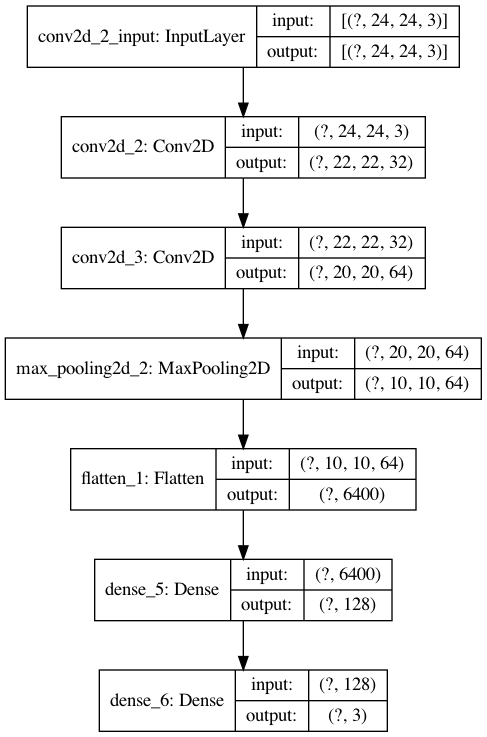

time: 404 ms (started: 2021-03-20 15:39:16 +09:00)


In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

tf.keras.utils.plot_model(model, show_shapes=True)
#SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

![model](http://tykimos.github.io/warehouse/2017-3-8_CNN_Getting_Started_3.svg)

---

### **모델 학습과정 설정하기**

모델을 정의했다면 모델을 손실함수와 최적화 알고리즘으로 엮어봅니다. 
- loss : 현재 가중치 세트를 평가하는 데 사용한 손실 함수 입니다. 다중 클래스 문제이므로 'categorical_crossentropy'으로 지정합니다.
- optimizer : 최적의 가중치를 검색하는 데 사용되는 최적화 알고리즘으로 효율적인 경사 하강법 알고리즘 중 하나인 'adam'을 사용합니다.
- metrics : 평가 척도를 나타내며 분류 문제에서는 일반적으로 'accuracy'으로 지정합니다.

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 14.7 ms (started: 2021-03-20 15:39:20 +09:00)


### **모델 학습시키기**

케라스에서는 모델을 학습시킬 때 주로 fit() 함수를 사용하지만 제네레이터로 생성된 배치로 학습시킬 경우에는 fit_generator() 함수를 사용합니다. 본 예제에서는 ImageDataGenerator라는 제네레이터로 이미지를 담고 있는 배치로 학습시키기 때문에 fit_generator() 함수를 사용하겠습니다.

- 첫번째 인자 : 훈련데이터셋을 제공할 제네레이터를 지정합니다. 본 예제에서는 앞서 생성한 train_generator으로 지정합니다.
- steps_per_epoch : 한 epoch에 사용한 스텝 수를 지정합니다. 총 45개의 훈련 샘플이 있고 배치사이즈가 3이므로 15 스텝으로 지정합니다.
- epochs : 전체 훈련 데이터셋에 대해 학습 반복 횟수를 지정합니다. 100번을 반복적으로 학습시켜 보겠습니다.
- validation_data : 검증데이터셋을 제공할 제네레이터를 지정합니다. 본 예제에서는 앞서 생성한 validation_generator으로 지정합니다.
- validation_steps : 한 epoch 종료 시 마다 검증할 때 사용되는 검증 스텝 수를 지정합니다. 홍 15개의 검증 샘플이 있고 배치사이즈가 3이므로 5 스텝으로 지정합니다.

In [23]:
model.fit_generator(
        train_generator,
        steps_per_epoch=15,
        epochs=50,
        validation_data=test_generator,
        validation_steps=5)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
15/15 [==============================] - 1s 41ms/step - loss: 1.1347 - accuracy: 0.5111 - val_loss: 0.6980 - val_accuracy: 0.8000
Epoch 2/50
15/15 [==============================] - 0s 17ms/step - loss: 0.3776 - accuracy: 0.9333 - val_loss: 0.2333 - val_accuracy: 1.0000
Epoch 3/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0791 - accuracy: 0.9778 - val_loss: 0.1363 - val_accuracy: 0.9333
Epoch 4/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0961 - val_accuracy: 0.9333
Epoch 5/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.1650 - val_accuracy: 0.9333
Epoch 6/50
15/15 [==============================] - 0s 18ms/step - loss: 8.1128e-04 - accuracy: 1.0000 - val_loss: 0.1889 - val_accuracy: 0.9333
Epoch 7/50
15/15 [==============================] - 0s 18ms/step - loss: 5

time: 17.3 s (started: 2021-03-20 15:39:23 +09:00)


---

### **모델 평가하기**

학습한 모델을 평가해봅니다. 제네레이터에서 제공되는 샘플로 평가할 때는 evaluate_generator 함수를 사용합니다.

In [24]:
print("-- Evaluate --")
scores = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
Instructions for updating:
Please use Model.evaluate, which supports generators.
accuracy: 93.33%
time: 100 ms (started: 2021-03-20 15:39:41 +09:00)


데이터셋이 적고 간단한 모델임에도 불구하고 100%라는 높은 정확도를 얻었습니다. 

---
### **모델 사용하기**

모델 사용 시에 제네레이터에서 제공되는 샘플을 입력할 때는 predict_generator 함수를 사용합니다. 예측 결과는 클래스별 확률 벡터로 출력되며, 클래스에 해당하는 열을 알기 위해서는 제네레이터의 'class_indices'를 출력하면 해당 열의 클래스명을 알려줍니다.

In [25]:
print("-- Predict --")
output = model.predict_generator(test_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(output)

-- Predict --
Instructions for updating:
Please use Model.predict, which supports generators.
{'circle': 0, 'rectangle': 1, 'triangle': 2}
[[0.000 1.000 0.000]
 [0.000 0.005 0.995]
 [0.000 1.000 0.000]
 [0.000 0.038 0.962]
 [0.000 0.000 1.000]
 [1.000 0.000 0.000]
 [1.000 0.000 0.000]
 [0.815 0.149 0.037]
 [0.000 0.000 1.000]
 [1.000 0.000 0.000]
 [0.000 0.000 1.000]
 [1.000 0.000 0.000]
 [0.999 0.000 0.001]
 [0.000 1.000 0.000]
 [0.000 1.000 0.000]]
time: 383 ms (started: 2021-03-20 15:39:41 +09:00)


---

### **전체 소스**

In [ ]:
# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# 랜덤시드 고정시키기
np.random.seed(3)

# 1. 데이터 생성하기
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'warehouse/handwriting_shape/train',
        target_size=(24, 24),
        batch_size=3,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'warehouse/handwriting_shape/test',
        target_size=(24, 24),    
        batch_size=3,
        class_mode='categorical')


# 2. 모델 구성하기
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(24,24,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
model.fit_generator(
        train_generator,
        steps_per_epoch=15,
        epochs=50,
        validation_data=test_generator,
        validation_steps=5)

# 6. 모델 평가하기
print("-- Evaluate --")
scores = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 7. 모델 사용하기
print("-- Predict --")
output = model.predict_generator(test_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(output)

---

### **요약**

이미지 분류 문제에 높은 성능을 보이고 있는 컨볼루션 신경망 모델을 이용하여 직접 만든 데이터셋으로 학습 및 평가를 해보았습니다. 학습 결과는 좋게 나왔지만 이 모델은 한 사람이 그린 것에 대해서만 학습이 되어 있어 다른 사람에 그린 모양은 분류를 잘 하지 못합니다. 이를 해결하기 위한 방안으로 '데이터 부풀리기' 기법이 있습니다.

## **4. CNN 학습을 위한 데이터 증강(augmentation)**

컨볼루션 신경망 모델의 성능을 높이기 위한 방법 중 하나인 데이터 부풀리기에 대해서 알아보겠습니다. 훈련셋이 부족하거나 훈련셋이 시험셋의 특성을 충분히 반영하지 못할 때 이 방법을 사용하면 모델의 성능을 크게 향상시킬 수 있습니다. 케라스에서는 데이터 부풀리기를 위한 함수를 제공하기 때문에 파라미터 셋팅만으로 간단히 데이터 부풀리기를 할 수 있습니다.

1. 현실적인 문제
1. 기존 모델 결과보기
1. 데이터 부풀리기
1. 개선 모델 결과보기

---

### **현실적인 문제**

앞서 [컨볼루션 신경망 모델 만들어보기](https://tykimos.github.io/2017/03/08/CNN_Getting_Started/)에서 사용하였던 원, 사각형, 삼각형 데이터셋을 예제로 살펴보겠습니다. 구성은 훈련셋과 시험셋으로 되어 있는 데, 아래 그림은 훈련셋입니다.

#### *훈련셋*
![data](http://tykimos.github.io/warehouse/2017-3-8-CNN_Data_Augmentation_1.png)

그리고 아래 그림은 시험셋입니다. 훈련셋과 시험셋은 모두 한사람(제가) 그린 것이라 거의 비슷합니다. 그래서 그런지 100% 정확도의 좋은 결과를 얻었나 봅니다.

#### *시험셋*
![data](http://tykimos.github.io/warehouse/2017-3-8-CNN_Data_Augmentation_2.png)

100% 정확도를 얻은 모델이니 원, 사각형, 삼각형을 그려주면 다 분류를 해보겠다며 지인에게 자랑을 해봅니다. 

그래서 지인이 그려준 시험셋은 다음과 같습니다.

#### *도전 시험셋*
![data](http://tykimos.github.io/warehouse/2017-3-8-CNN_Data_Augmentation_3.png)

막상 시험셋을 받아보니 자신감이 없어지면서 여러가지 생각이 듭니다.

- 아, 이것도 원, 사각형, 삼각형이구나
- 왜 이런 데이터를 진작에 학습시키지 않았을까?
- 새로 받은 시험셋 일부를 학습시켜볼까?
- 이렇게 간단한 문제도 개발과 현실과의 차이가 이렇게 나는데, 실제 문제는 더 상황이 좋지 않겠지?

결국 하나의 결론에 도달합니다.

    개발자가 시험셋을 만들면 안된다.

하지만 어떠한 문제에서도 미래에 들어올 데이터에 대해서는 알 수가 없기 때문에 비슷한 상황에 부딪히는 분들이 많을 것입니다. 먼저 도전 시험셋으로 시험한 결과를 살펴본 뒤, 한정적인 훈련셋을 이용하여 최대한 발생할 수 있는 경우을 고려하여 훈련셋을 만드는 방법인 `데이터 부풀리기`에 대해서 알아보겠습니다.


##### **도전 시험셋 다운로드 링크**

https://github.com/tykimos/tykimos.github.io/raw/master/warehouse/2017-3-8-CNN_Data_Augmentation_hard_handwriting_shape.zip


In [26]:
# Colab 환경에 데이터 받기
!wget https://github.com/tykimos/tykimos.github.io/raw/master/warehouse/2017-3-8-CNN_Data_Augmentation_hard_handwriting_shape.zip

--2021-03-20 15:40:03--  https://github.com/tykimos/tykimos.github.io/raw/master/warehouse/2017-3-8-CNN_Data_Augmentation_hard_handwriting_shape.zip
Resolving github.com (github.com)... 15.164.81.167
Connecting to github.com (github.com)|15.164.81.167|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tykimos/tykimos.github.io/master/warehouse/2017-3-8-CNN_Data_Augmentation_hard_handwriting_shape.zip [following]
--2021-03-20 15:40:03--  https://raw.githubusercontent.com/tykimos/tykimos.github.io/master/warehouse/2017-3-8-CNN_Data_Augmentation_hard_handwriting_shape.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335762 (328K) [application/zip]
Saving to: `2017-3-8-CNN_Data_Augmentation_hard_ha

In [27]:
# 데이터 경로(warehouse/)에 압축 해제하기
!unzip 2017-3-8-CNN_Data_Augmentation_hard_handwriting_shape.zip -d warehouse

Archive:  2017-3-8-CNN_Data_Augmentation_hard_handwriting_shape.zip
   creating: warehouse/hard_handwriting_shape/
  inflating: warehouse/hard_handwriting_shape/.DS_Store  
   creating: warehouse/__MACOSX/hard_handwriting_shape/
  inflating: warehouse/__MACOSX/hard_handwriting_shape/._.DS_Store  
   creating: warehouse/hard_handwriting_shape/test/
  inflating: warehouse/hard_handwriting_shape/test/.DS_Store  
   creating: warehouse/__MACOSX/hard_handwriting_shape/test/
  inflating: warehouse/__MACOSX/hard_handwriting_shape/test/._.DS_Store  
   creating: warehouse/hard_handwriting_shape/test/circle/
  inflating: warehouse/hard_handwriting_shape/test/circle/.DS_Store  
   creating: warehouse/__MACOSX/hard_handwriting_shape/test/circle/
  inflating: warehouse/__MACOSX/hard_handwriting_shape/test/circle/._.DS_Store  
  inflating: warehouse/hard_handwriting_shape/test/circle/circle021.png  
  inflating: warehouse/__MACOSX/hard_handwriting_shape/test/circle/._circle021.png  
  inflating: wa

---

### **기존 모델 결과보기**

[컨볼루션 신경망 모델 만들어보기](https://tykimos.github.io/2017/03/08/CNN_Getting_Started/)에서 사용했던 모델을 그대로 가지고 왔습니다. 제가 만든 시험셋('warehouse/handwriting_shape/test')에서는 결과가 100%나왔는데, 도전 시험셋('warehouse/hard_handwriting_shape/test')으론 어떤 결과가 나오는 지 테스트해보겠습니다.

In [28]:
# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# 랜덤시드 고정시키기
np.random.seed(3)

# 1. 데이터 생성하기
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'warehouse/hard_handwriting_shape/train',
        target_size=(24, 24),
        batch_size=3,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'warehouse/hard_handwriting_shape/test',
        target_size=(24, 24),    
        batch_size=3,
        class_mode='categorical')


# 2. 모델 구성하기
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(24,24,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
model.fit_generator(
        train_generator,
        steps_per_epoch=15,
        epochs=50,
        validation_data=test_generator,
        validation_steps=5)

# 5. 모델 평가하기
print("-- Evaluate --")
scores = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 6. 모델 사용하기
print("-- Predict --")
output = model.predict_generator(test_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(output)

Found 45 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Epoch 1/50
15/15 [==============================] - 0s 26ms/step - loss: 1.0505 - accuracy: 0.5556 - val_loss: 1.1554 - val_accuracy: 0.3333
Epoch 2/50
15/15 [==============================] - 0s 16ms/step - loss: 0.2856 - accuracy: 1.0000 - val_loss: 2.4156 - val_accuracy: 0.3333
Epoch 3/50
15/15 [==============================] - 0s 17ms/step - loss: 0.0413 - accuracy: 1.0000 - val_loss: 3.5967 - val_accuracy: 0.3333
Epoch 4/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 4.1167 - val_accuracy: 0.3333
Epoch 5/50
15/15 [==============================] - 0s 17ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 4.5145 - val_accuracy: 0.3333
Epoch 6/50
15/15 [==============================] - 0s 16ms/step - loss: 6.4444e-04 - accuracy: 1.0000 - val_loss: 4.7173 - val_accuracy: 0.3333
Epoch 7/50
15/15 [==============================] - 0s 22ms/step - los

훈련셋의 정확도는 100%에 가깝지만 시험셋의 평가결과는 33.3%입니다. 세 개 중 하나를 맞추는 문제에서 33.3%의 정확도는 사실상 의미없는 분류 모델입니다. 이 모델은 훈련셋에서만 결과가 좋은 오버피팅 된 모델이라고 볼 수 있습니다.

---

### **데이터 부풀리기**

케라스에서는 `ImageDataGenerator` 함수를 통해서 데이터 부풀리기 기능을 제공합니다. [keras.io](https://keras.io/preprocessing/image/#imagedatagenerator) 페이지를 보면, 아래와 같은 옵션으로 데이터 부풀리기를 할 수 있습니다.

    keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0.,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=K.image_data_format())

그럼 훈련셋 중 하나인 삼각형을 골라 데이터 부풀리기를 해보겠습니다. 원본이 되는 삼각형은 다음과 같습니다.

![data](http://tykimos.github.io/warehouse/2017-3-8-CNN_Data_Augmentation_4.png)

이 삼각형을 ImageDataGenerator 함수을 이용하여 각 파라미터별로 어떻게 부풀리기를 하는 지 살펴보겠습니다.

#### `rotation_range = 90`
지정된 각도 범위내에서 임의로 원본이미지를 회전시킵니다. 단위는 도이며, 정수형입니다. 예를 들어 90이라면 0도에서 90도 사이에 임의의 각도로 회전시킵니다.
![data](http://tykimos.github.io/warehouse/2017-3-8-CNN_Data_Augmentation_5_rotate.png)

#### `width_shift_range = 0.1`
지정된 수평방향 이동 범위내에서 임의로 원본이미지를 이동시킵니다. 수치는 전체 넓이의 비율(실수)로 나타냅니다. 예를 들어 0.1이고 전체 넓이가 100이면, 10픽셀 내외로 좌우 이동시킵니다.
![data](http://tykimos.github.io/warehouse/2017-3-8-CNN_Data_Augmentation_5_width_shift.png)

#### `height_shift_range = 0.1`
지정된 수직방향 이동 범위내에서 임의로 원본이미지를 이동시킵니다. 수치는 전체 높이의 비율(실수)로 나타냅니다. 예를 들어 0.1이고 전체 높이가 100이면, 10픽셀 내외로 상하 이동시킵니다.
![data](http://tykimos.github.io/warehouse/2017-3-8-CNN_Data_Augmentation_5_height_shift.png)

#### `shear_range = 0.5`
밀림 강도 범위내에서 임의로 원본이미지를 변형시킵니다. 수치는 시계반대방향으로 밀림 강도를 라디안으로 나타냅니다. 예를 들어 0.5이라면, 0.5 라이안내외로 시계반대방향으로 변형시킵니다.
![data](http://tykimos.github.io/warehouse/2017-3-8-CNN_Data_Augmentation_5_shear.png)

#### `zoom_range = 0.3`
지정된 확대/축소 범위내에서 임의로 원본이미지를 확대/축소합니다. "1-수치"부터 "1+수치"사이 범위로 확대/축소를 합니다. 예를 들어 0.3이라면, 0.7배에서 1.3배 크기 변화를 시킵니다.
![data](http://tykimos.github.io/warehouse/2017-3-8-CNN_Data_Augmentation_5_zoom.png)

#### `horizontal_flip = True`
수평방향으로 뒤집기를 합니다.
![data](http://tykimos.github.io/warehouse/2017-3-8-CNN_Data_Augmentation_5_horizontal_flip.png)

#### `vertical_flip = True`
수직방향으로 뒤집기를 합니다.
![data](http://tykimos.github.io/warehouse/2017-3-8-CNN_Data_Augmentation_5_vertical_flip.png)

#### *소스코드*

아래 코드는 ImageDataGenerator함수를 이용하여 지정된 파라미터로 원본이미지에 대해 데이터 부풀리기를 수행한 후 그 결과를 특정 폴더에 저장하는 코드입니다. 여러 파라미터를 사용하였기 때문에 이를 혼합하여 데이터 부풀리기를 수행합니다. 즉 확대/축소도 하고 좌우 이동도 지정하였다면, 축소하면서 좌로 이동된 이미지도 생성됩니다.

In [29]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(5)

# 데이터셋 생성하기
data_aug_gen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range=10,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.7,
                                  zoom_range=[0.9, 2.2],
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')
                                   
img = load_img('warehouse/hard_handwriting_shape/train/triangle/triangle001.png')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)


time: 8.04 ms (started: 2021-03-20 15:40:33 +09:00)


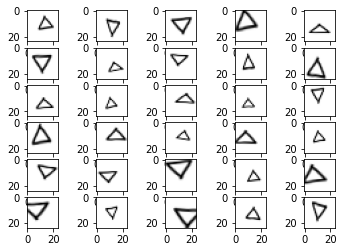

time: 4.58 s (started: 2021-03-20 15:40:34 +09:00)


In [30]:
i = 0

### 저장경로 폴더 생성
!mkdir -p warehouse/preview
### 이미지 출력
import matplotlib.pyplot as plt
fig = plt.figure()

# 이 for는 무한으로 반복되기 때문에 우리가 원하는 반복횟수를 지정하여, 지정된 반복횟수가 되면 빠져나오도록 해야합니다.
for batch in data_aug_gen.flow(x, batch_size=1, save_to_dir='warehouse/preview', save_prefix='tri', save_format='png'):
    i += 1
    if i > 30: 
        break
        
    ### 이미지 subplot
    ax = fig.add_subplot(6, 5, i)
    ax.imshow(batch.reshape(24, 24, 3))

plt.show()

위 코드로 데이터 부풀리기가 수행된 결과 이미지는 다음과 같습니다. 지인이 만든 도전 시험셋 중 비슷한 것들도 보입니다.

![data](http://tykimos.github.io/warehouse/2017-3-8-CNN_Data_Augmentation_5_combination.png)

---

### **개선 모델 결과보기**

데이터 부풀리기를 하기 위해서는 기존 코드에서 아래 코드를 추가합니다. 각 파라미터 설정 값에 따라 결과가 다르기 나오니, 실제 데이터에 있을만한 수준으로 적정값을 지정하셔야 합니다.

In [31]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.7,
                                   zoom_range=[0.9, 2.2],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

time: 573 µs (started: 2021-03-20 15:40:38 +09:00)


수정된 전체 코드는 다음과 같습니다. 참고로 시험셋은 데이터 부풀리기를 할 필요가 없으니, test_datagen 객체 생성 시에는 별도의 파라미터를 추가하지 않았습니다. 그리고 fit_generator함수에서 steps_per_epoch의 값은 기존 15개에서 더 많은 수 (현재 예는 1500개)로 설정합니다. batch_size * steps_per_epoch가 전체 샘플 수 인데, 데이터 부풀리기를 하지 않을 때는 기존의 15개의 배치사이즈(3개)로 전체 45개를 모두 학습에 사용할 수 있지만, ImageDataGenerator함수를 통해 데이터 부풀리기는 할 때는 하나의 샘플로 여러 개의 결과를 얻기 때문에 요청하는 데로 무한의 샘플이 제공됩니다. 여기서는 100배 정도인 1500개로 설정했습니다.

In [1]:
# 0. 사용할 패키지 불러오기
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout

# 랜덤시드 고정시키기
np.random.seed(3)

Using TensorFlow backend.


In [3]:
# 1. 데이터셋 생성하기
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.7,
                                   zoom_range=[0.9, 2.2],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'warehouse/hard_handwriting_shape/train',
        target_size=(24, 24),
        batch_size=3,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'warehouse/hard_handwriting_shape/test',
        target_size=(24, 24),    
        batch_size=3,
        class_mode='categorical')

Found 45 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
time: 227 ms (started: 2021-03-20 16:39:46 +09:00)


In [59]:
train_datagen

time: 15.7 ms (started: 2021-03-20 16:26:05 +09:00)


In [4]:
# 2. 모델 구성하기
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(24,24,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

time: 123 ms (started: 2021-03-20 16:39:52 +09:00)


In [5]:
# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 88.3 ms (started: 2021-03-20 16:39:53 +09:00)


In [6]:
# 4. 모델 학습시키기
### EarlyStop 추가 (val_loss가 2번 연속으로 개선되지 않으면 종료)
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=15 * 100,
        epochs=200,
        validation_data=test_generator,
        validation_steps=5, 
        callbacks=[early_stop])

Epoch 1/200
1500/1500 [==============================] - 33s 22ms/step - loss: 0.1829 - accuracy: 0.9224 - val_loss: 0.0596 - val_accuracy: 0.8000
Epoch 2/200
1500/1500 [==============================] - 32s 21ms/step - loss: 0.0361 - accuracy: 0.9880 - val_loss: 1.3463 - val_accuracy: 0.8667
Epoch 3/200
1500/1500 [==============================] - 33s 22ms/step - loss: 0.0321 - accuracy: 0.9904 - val_loss: 0.2767 - val_accuracy: 0.8000
Epoch 4/200
1500/1500 [==============================] - 38s 26ms/step - loss: 0.0274 - accuracy: 0.9924 - val_loss: 2.3933 - val_accuracy: 0.7333
Epoch 5/200
1500/1500 [==============================] - 39s 26ms/step - loss: 0.0188 - accuracy: 0.9947 - val_loss: 0.9084 - val_accuracy: 0.7333
Epoch 6/200
1500/1500 [==============================] - 34s 23ms/step - loss: 0.0159 - accuracy: 0.9951 - val_loss: 1.3812 - val_accuracy: 0.8667
time: 3min 31s (started: 2021-03-20 16:39:55 +09:00)


In [27]:
# 5. 모델 평가하기
print("-- Evaluate --")
scores = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
accuracy: 80.00%
time: 149 ms (started: 2021-03-20 19:24:13 +09:00)


In [28]:
# 6. 모델 사용하기
print("-- Predict --")
output = model.predict_generator(test_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(output)

-- Predict --
{'circle': 0, 'rectangle': 1, 'triangle': 2}
[[0.425 0.575 0.000]
 [0.000 0.001 0.999]
 [0.000 0.000 1.000]
 [0.000 1.000 0.000]
 [1.000 0.000 0.000]
 [0.000 1.000 0.000]
 [0.000 0.000 1.000]
 [1.000 0.000 0.000]
 [0.003 0.986 0.011]
 [0.000 0.000 1.000]
 [0.000 0.000 1.000]
 [1.000 0.000 0.000]
 [0.000 0.000 1.000]
 [0.000 1.000 0.000]
 [0.000 0.000 1.000]]
time: 133 ms (started: 2021-03-20 19:24:16 +09:00)


만족할만한 수준은 아니지만, 도전 시험셋으로 기존 모델을 시험했을 때의 결과가 50%를 못 미치는 수준에 비하면 비약적인 개선이 일어났습니다. 이는 동일한 모델을 사용하면서 훈련 데이터만 부풀려서 학습을 시켰을 뿐인데 성능 향상이 일어났습니다.

---

### **요약**

원, 삼각형, 사각형을 분류하는 간단한 문제에서도 개발 모델이 현실에 적용하기 위해서는 어떠한 어려움이 있는 지 알게되었습니다. 그리고 이를 극복하는 방안으로 데이터 부풀리기 방법에 대해서 알아보고, 각 파라미터 별로 어떻게 데이터를 부풀리는 지 생성된 이미지를 통해 살펴보왔습니다. 훈련셋이 충분하지 않거나 시험셋의 다양한 특성을 반영되어 있지 않다면 데이터 부풀리기 방법은 성능 개선에 큰 도움을 줄 수 있습니다. 

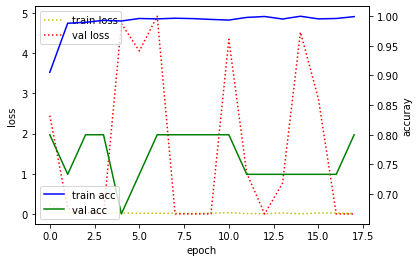

time: 1.07 s (started: 2021-03-20 19:24:21 +09:00)


In [29]:
### 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y:', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r:', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## **Lab 1**

4장의 <u>"도전 시험셋"에 대한 val_accuracy를 향상</u>시킬 수 있도록 수정합니다.

*   CNN 모델의 레이어 또는 파라미터를 자유롭게 조절
*   또는, 데이터 증강하는 ImageGenerator방법을 자유롭게 조절

실습코드의 결과를 초과하여 성능이 향상되는 구성을 만들어보고, 출력 결과를 확인합니다.

**※ 제출방법:** 실습내용 및 출력 결과가 저장된 Colab 파일(`*.ipynb`)를 KLMS의 과제 항목에 업로드

In [1]:
# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# 랜덤시드 고정시키기
np.random.seed(3)

Using TensorFlow backend.


In [30]:
# 1. 데이터 생성하기
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   shear_range=1.0,
                                   zoom_range=[0.9, 3.0],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'warehouse/hard_handwriting_shape/train',
        target_size=(24, 24),
        batch_size=3,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'warehouse/hard_handwriting_shape/test',
        target_size=(24, 24),    
        batch_size=3,
        class_mode='categorical')

Found 45 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
time: 250 ms (started: 2021-03-20 19:25:35 +09:00)


In [31]:
# 2. 모델 구성하기
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(24,24,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

time: 78.9 ms (started: 2021-03-20 19:25:37 +09:00)


In [32]:
# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 85.7 ms (started: 2021-03-20 19:25:38 +09:00)


In [33]:
# 4. 모델 학습시키기
### EarlyStop 추가 (val_loss가 2번 연속으로 개선되지 않으면 종료)
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=15 * 100,
        epochs=200,
        validation_data=test_generator,
        validation_steps=5, 
        callbacks=[early_stop])

Epoch 1/200
1500/1500 [==============================] - 33s 22ms/step - loss: 0.6792 - accuracy: 0.6973 - val_loss: 0.1140 - val_accuracy: 0.8000
Epoch 2/200
1500/1500 [==============================] - 36s 24ms/step - loss: 0.2946 - accuracy: 0.8911 - val_loss: 0.7270 - val_accuracy: 0.8000
Epoch 3/200
1500/1500 [==============================] - 32s 21ms/step - loss: 0.1887 - accuracy: 0.9300 - val_loss: 0.2223 - val_accuracy: 0.8000
Epoch 4/200
1500/1500 [==============================] - 31s 21ms/step - loss: 0.1385 - accuracy: 0.9504 - val_loss: 0.9303 - val_accuracy: 0.8000
Epoch 5/200
1500/1500 [==============================] - 35s 23ms/step - loss: 0.1183 - accuracy: 0.9560 - val_loss: 0.4745 - val_accuracy: 0.8000
Epoch 6/200
1500/1500 [==============================] - 39s 26ms/step - loss: 0.0940 - accuracy: 0.9649 - val_loss: 2.0360 - val_accuracy: 0.9333
time: 3min 26s (started: 2021-03-20 19:25:39 +09:00)


In [34]:
# 5. 모델 평가하기
print("-- Evaluate --")
scores = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
accuracy: 93.33%
time: 108 ms (started: 2021-03-20 19:29:05 +09:00)


In [35]:
# 6. 모델 사용하기
print("-- Predict --")
output = model.predict_generator(test_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(output)

-- Predict --
{'circle': 0, 'rectangle': 1, 'triangle': 2}
[[0.000 0.000 1.000]
 [0.004 0.996 0.000]
 [0.000 0.997 0.003]
 [0.908 0.092 0.000]
 [0.998 0.002 0.000]
 [0.000 0.981 0.019]
 [0.000 1.000 0.000]
 [0.000 0.954 0.046]
 [0.006 0.493 0.501]
 [0.000 0.002 0.998]
 [0.000 0.048 0.952]
 [0.000 0.008 0.992]
 [0.645 0.248 0.107]
 [0.969 0.030 0.001]
 [0.004 0.971 0.025]]
time: 141 ms (started: 2021-03-20 19:29:06 +09:00)


## **5. 사전학습된 VGG 모델 사용**

### **VGG-16 모델**

*참조 레퍼런스*

https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

<br />

**주요 파라미터**

*   `include_top (True)`: 
  - Whether or not to include the output layers for the model. You don’t need these if you are fitting the model on your own problem.
*   `weights ('imagenet')`: 
  - What weights to load. You can specify None to not load pre-trained weights if you are interested in training the model yourself from scratch.
*   `input_tensor (None)`: 
  - A new input layer if you intend to fit the model on new data of a different size.
*   `input_shape (None)`: 
  - The size of images that the model is expected to take if you change the input layer.
*   `pooling (None)`: 
  - The type of pooling to use when you are training a new set of output layers.
*   `classes (1000)`: 
  - The number of classes (e.g. size of output vector) for the model.

In [34]:
from keras.applications.vgg16 import VGG16
model = VGG16()

553467904/553467096 [==============================] - 155s 0us/step
time: 2min 38s (started: 2021-03-20 15:41:43 +09:00)


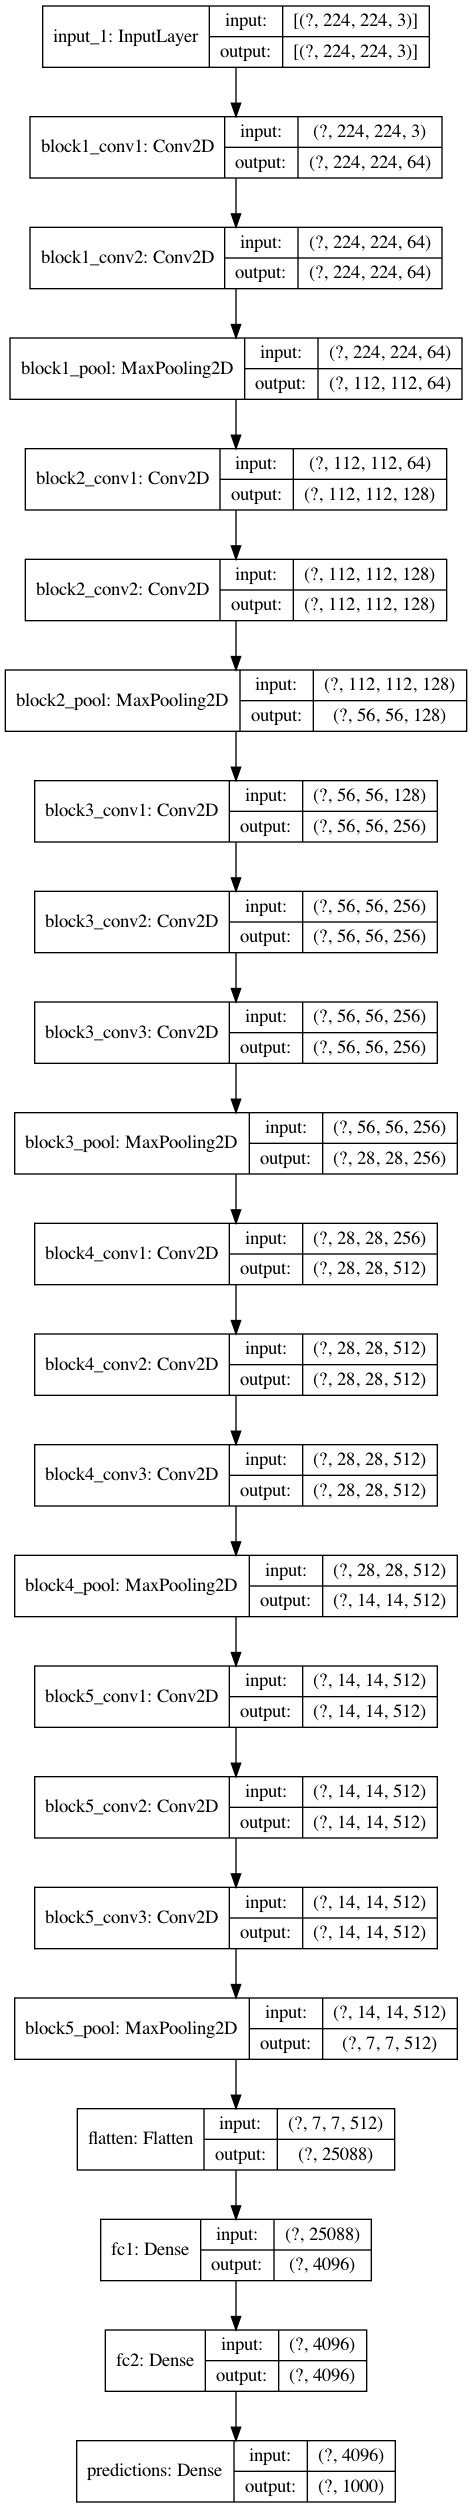

time: 686 ms (started: 2021-03-20 15:44:21 +09:00)


In [35]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

tf.keras.utils.plot_model(model, show_shapes=True)
#SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [36]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

##### *입력 이미지 데이터 준비*

VGG 모델에서는 입력 이미지를 224×224 크기로 사용합니다.

In [37]:
from keras.preprocessing.image import load_img
# load an image from file
path_img = 'warehouse/hard_handwriting_shape/train/triangle/triangle001.png'
image = load_img(path_img, target_size=(224, 224))

time: 2.7 ms (started: 2021-03-20 15:44:22 +09:00)


`Numpy` 배열로 변경하고, 기존 VGG 모델에 맞도록 추가 dimension을 포함하도록 `reshape()` 합니다.

In [38]:
from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)

time: 2.02 ms (started: 2021-03-20 15:46:17 +09:00)


In [39]:
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

time: 541 µs (started: 2021-03-20 15:46:17 +09:00)


Keras에서 제공하는 VGG모델의 입력 전처리 함수 `preprocess_input()`을 적용합니다.

In [40]:
from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)

time: 962 µs (started: 2021-03-20 15:46:24 +09:00)


##### *모델을 사용하여 예측 실행*

In [41]:
# predict the probability across all output classes
yhat = model.predict(image)

time: 553 ms (started: 2021-03-20 15:46:26 +09:00)


##### *예측결과 해석*

In [42]:
from keras.applications.vgg16 import decode_predictions
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

40960/35363 [==================================] - 0s 0us/step
airship (6.42%)
time: 321 ms (started: 2021-03-20 15:46:30 +09:00)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


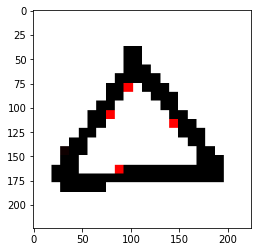

time: 427 ms (started: 2021-03-20 15:46:31 +09:00)


In [43]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.imshow(image.reshape(224, 224, 3))
plt.show()

#### *전체 코드 재정리 (함수화)*

In [44]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

# 입력 전처리 함수
def preproc_image_vgg(path_img):
  # load an image from file
  image = load_img(path_img, target_size=(224, 224))

  # convert the image pixels to a numpy array
  image = img_to_array(image)

  # reshape data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

  # prepare the image for the VGG model
  image = preprocess_input(image)

  return image

time: 1.39 ms (started: 2021-03-20 15:46:48 +09:00)


In [45]:
from keras.applications.vgg16 import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline

# 결과 해석 및 출력 함수
def print_result_vgg(yhat, image):
  # convert the probabilities to class labels
  label = decode_predictions(yhat)
  # retrieve the most likely result, e.g. highest probability
  label = label[0][0]
  # print the classification
  print('> Predicted Label=  %s (%.2f%%)' % (label[1], label[2]*100))

  # show an image
  plt.imshow(image.reshape(224, 224, 3))
  plt.show()

time: 3.21 ms (started: 2021-03-20 15:46:48 +09:00)


In [46]:
# VGG를 활용한 전체 예측과정 함수
def predict_vgg(path_img):
  image = preproc_image_vgg(path_img)

  # predict the probability across all output classes
  yhat = model.predict(image)

  print_result_vgg(yhat, image)

time: 1.19 ms (started: 2021-03-20 15:46:49 +09:00)


##### *실행결과 테스트*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
> Predicted Label=  airship (6.42%)


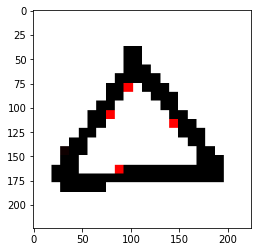

time: 888 ms (started: 2021-03-20 15:46:52 +09:00)


In [47]:
predict_vgg('warehouse/hard_handwriting_shape/train/triangle/triangle001.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
> Predicted Label=  envelope (18.01%)


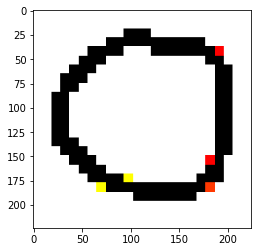

time: 819 ms (started: 2021-03-20 15:46:53 +09:00)


In [48]:
predict_vgg('warehouse/hard_handwriting_shape/train/circle/circle001.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
> Predicted Label=  television (25.52%)


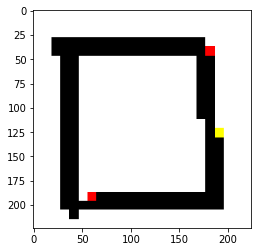

time: 913 ms (started: 2021-03-20 15:46:53 +09:00)


In [49]:
predict_vgg('warehouse/hard_handwriting_shape/train/rectangle/rectangle001.png')